# RNN Tutorial

Included in the data/names directory are 18 text files named as “[Language].txt”. Each file contains a bunch of names, one name per line, mostly romanized (but we still need to convert from Unicode to ASCII).

We’ll end up with a dictionary of lists of names per language, {language: [names ...]}. The generic variables “category” and “line” (for language and name in our case) are used for later extensibility.

In [97]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os

def findFiles(path): return glob.glob(path)

print(findFiles('./data/names/*.txt'))

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicodeToAscii('Ślusàrski'))

# Build the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

for filename in findFiles('./data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print(n_categories)

['./data/names\\Arabic.txt', './data/names\\Chinese.txt', './data/names\\Czech.txt', './data/names\\Dutch.txt', './data/names\\English.txt', './data/names\\French.txt', './data/names\\German.txt', './data/names\\Greek.txt', './data/names\\Irish.txt', './data/names\\Italian.txt', './data/names\\Japanese.txt', './data/names\\Korean.txt', './data/names\\Polish.txt', './data/names\\Portuguese.txt', './data/names\\Russian.txt', './data/names\\Scottish.txt', './data/names\\Spanish.txt', './data/names\\Vietnamese.txt']
Slusarski
18


Now we have category_lines, a dictionary mapping each category (language) to a list of lines (names). We also kept track of all_categories (just a list of languages) and n_categories for later reference.

In [98]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors
Now that we have all the names organized, we need to turn them into Tensors to make any use of them.

To represent a single letter, we use a “one-hot vector” of size <1 x n_letters>. A one-hot vector is filled with 0s except for a 1 at index of the current letter, e.g. "b" = <0 1 0 0 0 ...>.

To make a word we join a bunch of those into a 2D matrix <line_length x 1 x n_letters>.

That extra 1 dimension is because PyTorch assumes everything is in batches - we’re just using a batch size of 1 here.

In [99]:
import torch

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print(letterToTensor('J'))

print(lineToTensor('Jones').size())

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])
torch.Size([5, 1, 57])


### Creating the Network
Before autograd, creating a recurrent neural network in Torch involved cloning the parameters of a layer over several timesteps. The layers held hidden state and gradients which are now entirely handled by the graph itself. This means you can implement a RNN in a very “pure” way, as regular feed-forward layers.

This RNN module (mostly copied from the PyTorch for Torch users tutorial) is just 2 linear layers which operate on an input and hidden state, with a LogSoftmax layer after the output.

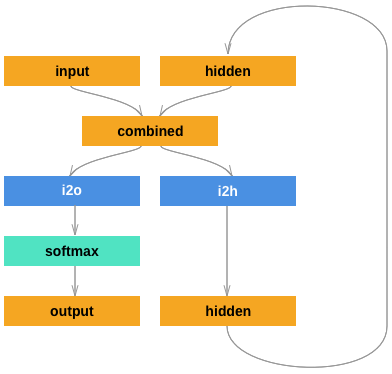

In [4]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

n_hidden = 128
lstm = RNN(n_letters, n_hidden, n_categories)
print(lstm)

RNN(
  (i2h): Linear(in_features=185, out_features=128, bias=True)
  (i2o): Linear(in_features=185, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=1)
)


In [48]:
import torch.nn as nn

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, input, h, c):
#         combined = torch.cat((input, hidden), 1)
        out, (h, c) = self.lstm(input, (h, c))
        output = self.out(out)
        output = self.softmax(output)
        return output, h, c

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size)

n_hidden = 64
lstm = LSTM(n_letters, n_hidden, n_categories)
print(lstm)

LSTM(
  (lstm): LSTM(57, 64)
  (out): Linear(in_features=64, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=-1)
)


In [129]:
import torch
import torch.nn as nn
from torch.nn import Parameter
from enum import IntEnum

class Dim(IntEnum):
    batch = 0
    seq = 1
    feature = 2

class MyLSTM(nn.Module):

    def __init__(self, input_size, hidden_size,num_classes):
        super(MyLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_classes = num_classes
        
        self.out = nn.Linear(hidden_size, num_classes)
        self.softmax = nn.LogSoftmax(dim=-1)
        
        # self.batch_first = batch_first

        # 输入门i_t
        self.W_i = Parameter(torch.Tensor(input_size, hidden_size))
        self.U_i = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_i = Parameter(torch.Tensor(hidden_size))
        # 遗忘门f_t
        self.W_f = Parameter(torch.Tensor(input_size, hidden_size))
        self.U_f = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_f = Parameter(torch.Tensor(hidden_size))
        # 候选内部状态g_t
        self.W_g = Parameter(torch.Tensor(input_size, hidden_size))
        self.U_g = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_g = Parameter(torch.Tensor(hidden_size))
        # 输出门o_t
        self.W_o = Parameter(torch.Tensor(input_size, hidden_size))
        self.U_o = Parameter(torch.Tensor(hidden_size, hidden_size))
        self.b_o = Parameter(torch.Tensor(hidden_size))

        # 初始化参数
        self._initialize_weights()
    
    def _initialize_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)

    def initHidden(self, x):
        h_t = torch.zeros(1, x.size(0), self.hidden_size, dtype=x.dtype).to(x.device)
        c_t = torch.zeros(1, x.size(0), self.hidden_size, dtype=x.dtype).to(x.device)
        return h_t, c_t

    def forward(self, x, init_states=None):

        # if self.batch_first:
        #     x = x.transpose(Dim.batch, Dim.seq)

        batch_size, seq_size, _ = x.size()
        hidden_seq = []

        # 状态初始化
        if init_states is None:
            h_t, c_t = self.initHidden(x)
        else:
            h_t, c_t = init_states

        for t in range(seq_size):
            x_t = x[:, t, :]
            i_t = torch.sigmoid(x_t @ self.W_i + h_t @ self.U_i.T + self.b_i)
            f_t = torch.sigmoid(x_t @ self.W_f + h_t @ self.U_f.T + self.b_f)
            g_t = torch.tanh(x_t @ self.W_g + h_t @ self.U_g.T + self.b_g)
            o_t = torch.sigmoid(x_t @ self.W_o + h_t @ self.U_o.T + self.b_o)
            c_t = f_t * c_t + i_t * g_t
            h_t = o_t * torch.tanh(c_t)
            # hidden_seq.append(h_t.unsqueeze(Dim.seq))
            hidden_seq.append(h_t)
        # print(hidden_seq.size())
        hidden_seq = torch.cat(hidden_seq, dim=Dim.batch)
        # print(hidden_seq.size())
        hidden_seq = hidden_seq.transpose(Dim.batch, Dim.seq).contiguous()
        # print(hidden_seq.size())

        output = self.out(hidden_seq)
        output = self.softmax(output)
        return output, h_t, c_t
n_hidden = 64
lstm=MyLSTM(n_letters, n_hidden, n_categories)
print(lstm)


MyLSTM(
  (out): Linear(in_features=64, out_features=18, bias=True)
  (softmax): LogSoftmax(dim=-1)
)


To run a step of this network we need to pass an input (in our case, the Tensor for the current letter) and a previous hidden state (which we initialize as zeros at first). We’ll get back the output (probability of each language) and a next hidden state (which we keep for the next step).

In [130]:
input = letterToTensor('A')
print(input.size())
# hidden = torch.zeros(1, n_hidden)

# rnn
# h=lstm.initHidden()
# output, h = lstm(input, h)

# print(output.size())

# lstm
h, c = lstm.initHidden(input.unsqueeze(1))
# output,h,c = lstm(input.unsqueeze(1), h, c)

output,h,c = lstm(input.unsqueeze(1), (h, c))
print(h.size())
print(c.size())
print(output[-1].size())

torch.Size([1, 57])
torch.Size([1, 1, 64])
torch.Size([1, 1, 64])
torch.Size([1, 18])


For the sake of efficiency we don’t want to be creating a new Tensor for every step, so we will use lineToTensor instead of letterToTensor and use slices. This could be further optimized by pre-computing batches of Tensors.

In [131]:
input = lineToTensor('Albert')
print(input.size())
hidden = torch.zeros(1, n_hidden)
# print(hidden)

# rnn
# h = lstm.initHidden()
# print(h.size())
# for i in range(input.size()[0]):
#     output,h = lstm(input[i], h)
# print(output.size())
# output, h = lstm(input, h)
# print(torch.exp(output))

# lstm
h, c = lstm.initHidden(input)
output, h, c = lstm(input, (h, c))
# print(output)
# print(output[-1])
print(output[-1].size())
# print(h.size())
# print(c.size())
# print(torch.exp(output))

torch.Size([6, 1, 57])
torch.Size([1, 18])


As you can see the output is a <1 x n_categories> Tensor, where every item is the likelihood of that category (higher is more likely).

### Preparing for Training
Before going into training we should make a few helper functions. The first is to interpret the output of the network, which we know to be a likelihood of each category. We can use Tensor.topk to get the index of the greatest value:

In [136]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

print(categoryFromOutput(output[-1]))

('French', 5)


We will also want a quick way to get a training example (a name and its language):

In [137]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    # print(line_tensor)
    print(line_tensor.size())
    print(category_tensor)
    print('category =', category, '/ line =', line)

torch.Size([6, 1, 57])
tensor([3])
category = Dutch / line = Hautum
torch.Size([5, 1, 57])
tensor([16])
category = Spanish / line = Garza
torch.Size([8, 1, 57])
tensor([15])
category = Scottish / line = Docherty
torch.Size([4, 1, 57])
tensor([9])
category = Italian / line = Agli
torch.Size([11, 1, 57])
tensor([14])
category = Russian / line = Shakhnovsky
torch.Size([6, 1, 57])
tensor([2])
category = Czech / line = Ocasek
torch.Size([6, 1, 57])
tensor([10])
category = Japanese / line = Yamaha
torch.Size([3, 1, 57])
tensor([1])
category = Chinese / line = Wen
torch.Size([7, 1, 57])
tensor([2])
category = Czech / line = Kolacny
torch.Size([9, 1, 57])
tensor([7])
category = Greek / line = Petimezas


### Training the Network
Now all it takes to train this network is show it a bunch of examples, have it make guesses, and tell it if it’s wrong.

For the loss function nn.NLLLoss is appropriate, since the last layer of the RNN is nn.LogSoftmax.

In [138]:
criterion = nn.NLLLoss()

Each loop of training will:

- Create input and target tensors
- Create a zeroed initial hidden state
- Read each letter in and keep hidden state for next letter
- Compare final output to target
- Back-propagate
- Return the output and loss

In [139]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn


# rnn
# def train(category_tensor, line_tensor):
#     hidden = lstm.initHidden()

#     lstm.zero_grad()

#     # print(line_tensor.size())
#     for i in range(line_tensor.size()[0]):
#         output, hidden = lstm(line_tensor[i], hidden)

#     loss = criterion(output, category_tensor)
#     loss.backward()

#     # Add parameters' gradients to their values, multiplied by learning rate
#     for p in lstm.parameters():
#         p.data.add_(p.grad.data, alpha=-learning_rate)

#     return output, loss.item()

# lstm
def train(category_tensor, line_tensor):
    h0, c0 = lstm.initHidden(line_tensor)

    lstm.zero_grad()

#     print(line_tensor.size())
#     for i in range(line_tensor.size()[0]):
#         output, hidden = rnn(line_tensor[i], hidden)
    output, h, c = lstm(line_tensor, (h0, c0))

    loss = criterion(output[-1], category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in lstm.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the train function returns both the output and loss we can print its guesses and also keep track of loss for plotting. Since there are 1000s of examples we print only every print_every examples, and take an average of the loss.

In [140]:
import time
import math

n_iters = 300000
# print_every = 5000
print_every = 5000
plot_every = 1000



# Keep track of losses for plotting
current_loss = 0
all_losses = []

correct_count = 0
all_accuracy = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    guess, guess_i = categoryFromOutput(output[-1])
    # guess, guess_i = categoryFromOutput(output)
    correct = '✓' if guess == category else '✗ (%s)' % category
    if correct == '✓':
        correct_count += 1

    # Print iter number, loss, name and guess
    if iter % print_every == 0:
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))
        
        accuracy = correct_count / print_every * 100
        print('%d %d%% (%s) %.4f %s / %s %s Accuracy: %.2f%%' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct, accuracy))
        all_accuracy.append(accuracy)
        correct_count = 0  # 重置正确计数

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 1% (0m 4s) 2.8752 Hoshino / Italian ✗ (Japanese)
5000 1% (0m 4s) 2.8752 Hoshino / Italian ✗ (Japanese) Accuracy: 8.36%
10000 3% (0m 9s) 2.9153 Wirner / Scottish ✗ (German)
10000 3% (0m 9s) 2.9153 Wirner / Scottish ✗ (German) Accuracy: 14.88%
15000 5% (0m 14s) 2.8480 Rameckers / Greek ✗ (Dutch)
15000 5% (0m 14s) 2.8480 Rameckers / Greek ✗ (Dutch) Accuracy: 19.84%
20000 6% (0m 18s) 2.6195 Scordato / Italian ✓
20000 6% (0m 18s) 2.6195 Scordato / Italian ✓ Accuracy: 25.20%
25000 8% (0m 22s) 2.6455 Lieu / Vietnamese ✓
25000 8% (0m 22s) 2.6455 Lieu / Vietnamese ✓ Accuracy: 25.54%
30000 10% (0m 27s) 2.8117 Kalb / German ✗ (Arabic)
30000 10% (0m 27s) 2.8117 Kalb / German ✗ (Arabic) Accuracy: 27.84%
35000 11% (0m 31s) 2.7314 Nader / German ✗ (Arabic)
35000 11% (0m 31s) 2.7314 Nader / German ✗ (Arabic) Accuracy: 27.70%
40000 13% (0m 36s) 2.4623 Quigley / Russian ✗ (Irish)
40000 13% (0m 36s) 2.4623 Quigley / Russian ✗ (Irish) Accuracy: 28.08%
45000 15% (0m 41s) 2.3819 Vann / Irish ✗ (English

### Plotting the Results
Plotting the historical loss from all_losses shows the network learning:

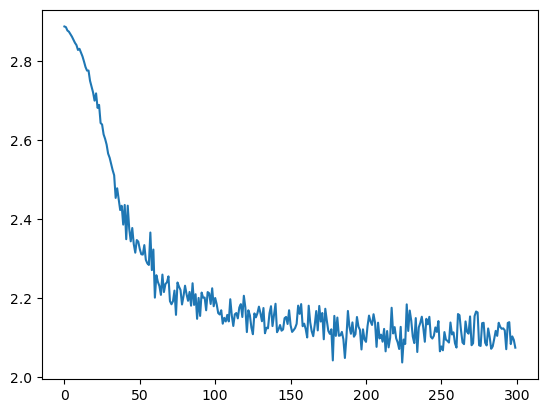

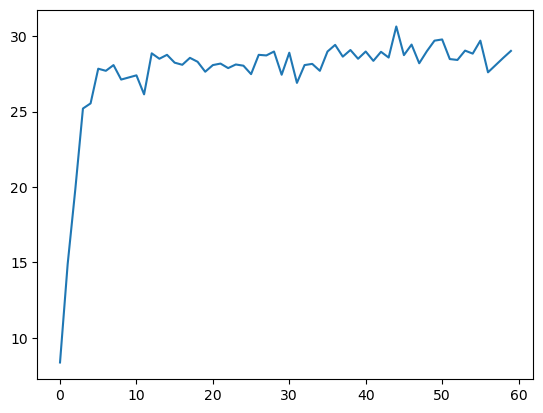

In [141]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

plt.figure()
plt.plot(all_accuracy)


### Evaluating the Results
To see how well the network performs on different categories, we will create a confusion matrix, indicating for every actual language (rows) which language the network guesses (columns). To calculate the confusion matrix a bunch of samples are run through the network with evaluate(), which is the same as train() minus the backprop.

C:\Users\29467\AppData\Local\Temp\ipykernel_2972\2733165307.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + all_categories, rotation=90)
C:\Users\29467\AppData\Local\Temp\ipykernel_2972\2733165307.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + all_categories)


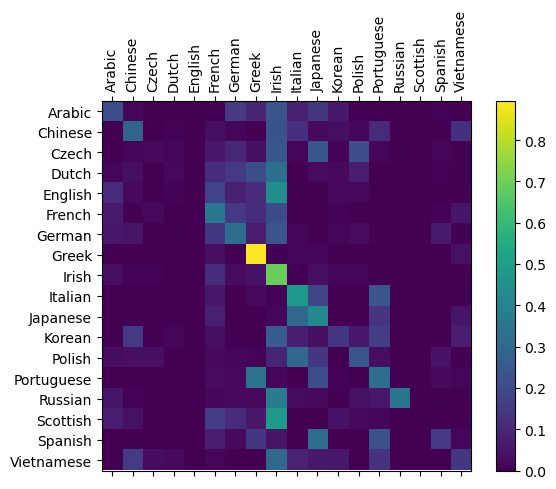

In [142]:
# Keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

# Just return an output given a line
def evaluate(line_tensor):
    h0, c0 = lstm.initHidden(line_tensor)

#     for i in range(line_tensor.size()[0]):
    output, h, c = lstm(line_tensor, (h0, c0))

    return output[-1]

# rnn
# def evaluate(line_tensor):
#     h = lstm.initHidden()

#     for i in range(line_tensor.size()[0]):
#         output, h = lstm(line_tensor[i], h)

#     return output

# Go through a bunch of examples and record which are correctly guessed
for i in range(n_confusion):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()

You can pick out bright spots off the main axis that show which languages it guesses incorrectly, e.g. Chinese for Korean, and Spanish for Italian. It seems to do very well with Greek, and very poorly with English (perhaps because of overlap with other languages).

### Running on User Input

In [24]:
import math
import numpy as np

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (np.exp(value), all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Hou')


> Dovesky
(0.56) Czech
(0.34) Russian
(0.09) English

> Jackson
(0.77) Scottish
(0.20) English
(0.01) Greek

> Hou
(0.54) Chinese
(0.38) Korean
(0.07) Vietnamese
